In [11]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# trial-trial

In [3]:
# Define the paths to the images
left_image_path = r'C:\Users\Yashraj Deshmukh\Desktop\Panaroma-Stitching\Images\I3\3_3.jpg'
right_image_path = r'C:\Users\Yashraj Deshmukh\Desktop\Panaroma-Stitching\Images\I3\3_4.jpg'

# Load the images
left_image = cv2.imread(left_image_path)
right_image = cv2.imread(right_image_path)

In [10]:
def detect_and_match_features(image1, image2, nfeatures=100):
    """
    Detect keypoints and descriptors using SIFT and match them between two images.
    """
    sift = cv2.SIFT_create()  # Initialize SIFT detector
    keypoints_left, descriptors_left = sift.detectAndCompute(image1, None)
    keypoints_right, descriptors_right = sift.detectAndCompute(image2, None)

    # Initialize the BFMatcher
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    # Match descriptors
    matches = bf.match(descriptors_left, descriptors_right)
    # Sort matches based on distance
    matches = sorted(matches, key=lambda x: x.distance)

    # Ensure that the matches are unique
    filtered_matches = []
    filtered_matches.append(matches[0])
    for match in matches[1:nfeatures]:
        if match.queryIdx not in [m.queryIdx for m in filtered_matches] and match.trainIdx not in [m.trainIdx for m in filtered_matches]:
            filtered_matches.append(match)

    # Get the keypoints corresponding to the matches
    correspondences = []
    for match in filtered_matches:
        correspondences.append((keypoints_left[match.queryIdx].pt, keypoints_right[match.trainIdx].pt))

    return np.array(correspondences)

In [11]:
x = detect_and_match_features(left_image, right_image)

In [12]:
len(x), x[:3]

(100,
 array([[[538.38049316, 198.19094849],
         [202.21087646, 194.04898071]],
 
        [[612.88842773,  93.23892975],
         [270.70516968,  92.30213928]],
 
        [[564.50537109,  71.44009399],
         [224.0267334 ,  69.2257309 ]]]))

In [ ]:
def warpAndPlaceSourceImage(source_img, homography_matrix, dest_img, offset=(0, 0)):
    height, width, _ = source_img.shape
    homography_inv = np.linalg.inv(homography_matrix)

    x_min, x_max, y_min, y_max = computeBoundingBoxOfWarpedImage(homography_matrix, width, height)
    
    coords = np.indices((x_max - x_min, y_max - y_min)).reshape(2, -1)
    coords += np.array([[x_min], [y_min]])
    homogeneous_coords = np.vstack((coords, np.ones(coords.shape[1])))
    
    transformed_coords = np.dot(homography_inv, homogeneous_coords)
    transformed_coords /= transformed_coords[2, :]
    
    x_input, y_input = transformed_coords.astype(np.int32)[:2, :]
    valid_indices = np.where((x_input >= 0) & (x_input < width) & (y_input >= 0) & (y_input < height))
    dest_img[coords[1, valid_indices] + offset[1], coords[0, valid_indices] + offset[0]] = source_img[y_input[valid_indices], x_input[valid_indices]]

In [ ]:
class PanaromaStitcher():
    def __init__(self):
        pass

    def detect_and_match_features(self, image1, image2, nfeatures=100):
        """
        Detect keypoints and descriptors using SIFT and match them between two images.
        """
        sift = cv2.SIFT_create()  # Initialize SIFT detector
        keypoints_left, descriptors_left = sift.detectAndCompute(image1, None)
        keypoints_right, descriptors_right = sift.detectAndCompute(image2, None)

        # Initialize the BFMatcher
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
        # Match descriptors
        matches = bf.match(descriptors_left, descriptors_right)
        # Sort matches based on distance
        matches = sorted(matches, key=lambda x: x.distance)

        # Ensure that the matches are unique
        filtered_matches = []
        filtered_matches.append(matches[0])
        for match in matches[1:nfeatures]:
            if match.queryIdx not in [m.queryIdx for m in filtered_matches] and match.trainIdx not in [m.trainIdx for m in filtered_matches]:
                filtered_matches.append(match)

        # Get the keypoints corresponding to the matches
        correspondences = []
        for match in filtered_matches:
            correspondences.append((keypoints_left[match.queryIdx].pt, keypoints_right[match.trainIdx].pt))

        return np.array(correspondences)

    def _compute_homography(self, correspondences):
        """
        Computes the homography matrix from 4 pairs of correspondences.
        """
        A = []
        for (x, y), (x_prime, y_prime) in correspondences:
            A.append([-x, -y, -1, 0, 0, 0, x_prime * x, x_prime * y, x_prime])
            A.append([0, 0, 0, -x, -y, -1, y_prime * x, y_prime * y, y_prime])

        A = np.array(A)

        # Compute SVD of A
        _, _, Vt = np.linalg.svd(A)
        # The last row of Vt (or last column of V) gives the solution
        H = Vt[-1].reshape(3, 3)
        return H / H[-1, -1]  # Normalize so that H[2, 2] = 1
    
    def get_homography_via_RANSAC(self, correspondences, trials=1000, threshold=5.0):
        """
        Estimates the homography matrix using RANSAC.
        
        Parameters:
            correspondences (ndarray): Array of point pairs [(x1, y1), (x2, y2)].
            trials (int): Number of RANSAC iterations to perform.
            threshold (float): Distance threshold to consider a point an inlier.
            
        Returns:
            best_H (ndarray): Best homography matrix found.
            best_inliers (list): List of inliers that agree with best_H.
        """
        if len(correspondences) < 4:
            raise ValueError("Not enough matches to compute homography.")

        max_inliers = []
        best_H = None

        num_points = correspondences.shape[0]

        for _ in range(trials):
            # Randomly select 4 correspondences to compute the homography
            sample_indices = np.random.choice(num_points, 4, replace=False)
            sample_correspondences = correspondences[sample_indices]

            # Compute homography for the sample
            H = self._compute_homography(sample_correspondences)

            # Calculate the number of inliers
            inliers = []
            for (x, y), (x_prime, y_prime) in correspondences:
                # Transform (x, y) using the estimated homography
                transformed_point = np.dot(H, np.array([x, y, 1]))
                transformed_point /= transformed_point[2]  # Normalize

                # Calculate the Euclidean distance between the transformed and actual points
                distance = np.linalg.norm(transformed_point[:2] - np.array([x_prime, y_prime]))

                if distance < threshold:
                    inliers.append(((x, y), (x_prime, y_prime)))

            # Update the best homography if the current set has more inliers
            if len(inliers) > len(max_inliers):
                max_inliers = inliers
                best_H = H

        # Recompute the homography using all inliers of the best model
        if best_H is not None:
            best_H = self._compute_homography(max_inliers)

        return best_H

    def _compute_bounding_box(self, image, H):
        """
        Computes the bounding box of the transformed image using the homography matrix.

        Parameters:
            image (ndarray): The input image.
            H (ndarray): The homography matrix.

        Returns:
            x_min, y_min, x_max, y_max: Coordinates of the bounding box.
        """
        h, w = image.shape[:2]
        
        # Define the four corners of the image
        corners = np.array([
            [0, 0, 1],          # Top-left
            [w - 1, 0, 1],      # Top-right
            [w - 1, h - 1, 1],  # Bottom-right
            [0, h - 1, 1]       # Bottom-left
        ])

        # Apply the homography matrix to the corners
        transformed_corners = []
        for corner in corners:
            transformed_corner = np.dot(H, corner)
            transformed_corner /= transformed_corner[2]  # Normalize by third coordinate
            transformed_corners.append(transformed_corner[:2])
        
        # Get min and max x, y coordinates from the transformed corners
        transformed_corners = np.array(transformed_corners)
        x_min, y_min = np.min(transformed_corners, axis=0)
        x_max, y_max = np.max(transformed_corners, axis=0)

        return int(x_min), int(y_min), int(x_max), int(y_max)


    def make_panaroma_for_images_in(self, path):
        # Load all images from the path
        all_images = sorted(glob.glob(os.path.join(path, '*')))

        if len(all_images) < 2:
            raise ValueError("Need at least two images to create a panorama.")

        # Read the first image as the base image
        base_image = cv2.imread(all_images[0])
        homography_matrix_list = []


In [ ]:
import cv2
import os
import glob
import numpy as np
import logging

# Set up logging configuration
logging.basicConfig(
    filename='panorama_stitcher.log',
    level=logging.DEBUG,
    format='%(asctime)s %(levelname)s:%(message)s'
)

def resize_image(image):
    """
    Resize the image based on its shape.
    
    Args:
    - image (numpy.ndarray): The input image.
    
    Returns:
    - numpy.ndarray: The resized image.
    """
    height, width, channels = image.shape
    
    if (height, width) == (2448, 3264) or (height, width) == (2658, 4000):
        # Reduce the size by a factor of 4
        new_height = height // 4
        new_width = width // 4
    elif (height, width) == (1329, 2000):
        # Reduce the size by half
        new_height = height // 2
        new_width = width // 2
    else:
        # Pass the image as it is
        return image
    
    # Log change in size
    logging.info("Resizing image from (%d, %d) to (%d, %d)", height, width, new_height, new_width)
    
    # Resize the image
    resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)
    
    return resized_image

class PanaromaStitcher():
    def __init__(self):
        pass

    def detect_and_match_features(self, image1, image2, nfeatures=100):
        """
        Detect keypoints and descriptors using SIFT and match them between two images.
        """
        try:
            sift = cv2.SIFT_create()  # Initialize SIFT detector
            keypoints_left, descriptors_left = sift.detectAndCompute(image1, None)
            keypoints_right, descriptors_right = sift.detectAndCompute(image2, None)

            # Initialize the BFMatcher
            bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
            # Match descriptors
            matches = bf.match(descriptors_left, descriptors_right)
            # Sort matches based on distance
            matches = sorted(matches, key=lambda x: x.distance)

            # Log the number of matches found
            logging.info("Found %d matches between the images", len(matches))

            # Get the keypoints corresponding to the matches
            correspondences = []
            for match in matches[:nfeatures]:
                correspondences.append((keypoints_left[match.queryIdx].pt, keypoints_right[match.trainIdx].pt))
            
            return np.array(correspondences)

        except Exception as e:
            logging.error("Error in detect_and_match_features: %s", e)
            raise

    def _compute_homography(self, correspondences):
        """
        Computes the homography matrix from 4 pairs of correspondences.
        """
        A = []
        for (x, y), (x_prime, y_prime) in correspondences:
            A.append([-x, -y, -1, 0, 0, 0, x_prime * x, x_prime * y, x_prime])
            A.append([0, 0, 0, -x, -y, -1, y_prime * x, y_prime * y, y_prime])

        A = np.array(A)

        # Compute SVD of A
        _, _, Vt = np.linalg.svd(A)
        # The last row of Vt (or last column of V) gives the solution
        H = Vt[-1].reshape(3, 3)
        return H / H[-1, -1]  # Normalize so that H[2, 2] = 1
    
    def get_homography_via_RANSAC(self, correspondences, trials=1000, threshold=5.0):
        """
        Estimates the homography matrix using RANSAC.
        
        Parameters:
            correspondences (ndarray): Array of point pairs [(x1, y1), (x2, y2)].
            trials (int): Number of RANSAC iterations to perform.
            threshold (float): Distance threshold to consider a point an inlier.
            
        Returns:
            best_H (ndarray): Best homography matrix found.
            best_inliers (list): List of inliers that agree with best_H.
        """
        try:
            if len(correspondences) < 4:
                raise ValueError("Not enough matches to compute homography.")

            max_inliers = []
            best_H = None

            num_points = correspondences.shape[0]

            for _ in range(trials):
                # Randomly select 4 correspondences to compute the homography
                sample_indices = np.random.choice(num_points, 4, replace=False)
                sample_correspondences = correspondences[sample_indices]

                # Compute homography for the sample
                H = self._compute_homography(sample_correspondences)

                # Calculate the number of inliers
                inliers = []
                for (x, y), (x_prime, y_prime) in correspondences:
                    # Transform (x, y) using the estimated homography
                    transformed_point = np.dot(H, np.array([x, y, 1]))
                    transformed_point /= transformed_point[2]  # Normalize

                    # Calculate the Euclidean distance between the transformed and actual points
                    distance = np.linalg.norm(transformed_point[:2] - np.array([x_prime, y_prime]))

                    if distance < threshold:
                        inliers.append(((x, y), (x_prime, y_prime)))

                # Update the best homography if the current set has more inliers
                if len(inliers) > len(max_inliers):
                    max_inliers = inliers
                    best_H = H

            # Recompute the homography using all inliers of the best model
            if best_H is not None:
                best_H = self._compute_homography(max_inliers)

            return best_H

        except Exception as e:
            logging.error("Error in get_homography: %s", e)
            raise

    def _bilinear_interpolation(self, image, x, y):
        """
        Performs bilinear interpolation for the given (x, y) coordinates.

        Parameters:
            image (ndarray): The input image.
            x (float): The x-coordinate (non-integer) in the image.
            y (float): The y-coordinate (non-integer) in the image.

        Returns:
            interpolated_value (ndarray): The interpolated RGB value.
        """
        x1, y1 = int(x), int(y)
        x2, y2 = min(x1 + 1, image.shape[1] - 1), min(y1 + 1, image.shape[0] - 1)

        # Calculate the distances
        dx, dy = x - x1, y - y1

        # Get pixel values from the four corners
        top_left = image[y1, x1]
        top_right = image[y1, x2]
        bottom_left = image[y2, x1]
        bottom_right = image[y2, x2]

        # Interpolate along x for the top and bottom edges
        top = (1 - dx) * top_left + dx * top_right
        bottom = (1 - dx) * bottom_left + dx * bottom_right

        # Interpolate along y between the top and bottom edges
        interpolated_value = (1 - dy) * top + dy * bottom

        return np.clip(interpolated_value, 0, 255).astype(np.uint8)
    
    def _compute_bounding_box(self, right_image, H):
        """
        Computes the bounding box of the transformed right_image in the panorama space.

        Parameters:
            right_image (ndarray): The right image to be warped.
            H (ndarray): The homography matrix for transforming the right image.

        Returns:
            x_min, x_max, y_min, y_max (tuple): Bounding box coordinates for the transformed right image.
        """
        height, width = right_image.shape[:2]
        corners = np.array([[0, 0, 1], [width, 0, 1], [width, height, 1], [0, height, 1]]).T
        transformed_corners = H @ corners
        transformed_corners /= transformed_corners[2]  # Normalize by the homogeneous coordinate

        # Calculate min and max x, y coordinates for the bounding box
        x_min, x_max = int(np.floor(transformed_corners[0].min())), int(np.ceil(transformed_corners[0].max()))
        y_min, y_max = int(np.floor(transformed_corners[1].min())), int(np.ceil(transformed_corners[1].max()))

        return x_min, x_max, y_min, y_max

    def warp_image(self, right_image, H, left_image_shape):
        """
        Warps the right_image onto a larger canvas using homography H and places it within the appropriate bounding box.

        Parameters:
            right_image (ndarray): The right image to be transformed.
            H (ndarray): The homography matrix for transforming right_image.
            left_image_shape (tuple): The shape of the left image (height, width, channels).

        Returns:
            warped_canvas (ndarray): The transformed and warped image on the canvas.
            offset (tuple): The (x_offset, y_offset) for placing both images on the canvas.
        """
        # Compute bounding box of the transformed right image
        x_min, x_max, y_min, y_max = self._compute_bounding_box(right_image, H)

        # Calculate canvas dimensions and offset
        canvas_width = max(x_max, left_image_shape[1]) - min(x_min, 0)
        canvas_height = max(y_max, left_image_shape[0]) - min(y_min, 0)
        x_offset = -min(x_min, 0)
        y_offset = -min(y_min, 0)

        # Log bounding box, canvas dimensions, and offset
        logging.info("Bounding box: (%d, %d, %d, %d)", x_min, x_max, y_min, y_max)
        logging.info("Canvas dimensions: (%d, %d)", canvas_width, canvas_height)
        logging.info("Offset: (%d, %d)", x_offset, y_offset)

        # Initialize the canvas
        warped_canvas = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)

        # Calculate inverse homography for mapping canvas pixels back to right_image coordinates
        H_inv = np.linalg.inv(H)

        # Generate grid of pixel coordinates within the bounding box
        x_coords, y_coords = np.meshgrid(np.arange(x_min, x_max + 1), np.arange(y_min, y_max + 1))
        coords_homogeneous = np.stack([x_coords.flatten(), y_coords.flatten(), np.ones_like(x_coords.flatten())])

        # Map canvas coordinates back to source (right_image) coordinates using inverse homography
        transformed_coords = H_inv @ coords_homogeneous
        transformed_coords /= transformed_coords[2]  # Normalize to get (x, y) coordinates in right_image

        x_src = transformed_coords[0].reshape(y_coords.shape)
        y_src = transformed_coords[1].reshape(y_coords.shape)

        # Apply bilinear interpolation on valid transformed coordinates and fill the canvas
        for i in range(y_coords.shape[0]):
            for j in range(x_coords.shape[1]):
                x, y = x_src[i, j], y_src[i, j]
                if 0 <= x < right_image.shape[1] and 0 <= y < right_image.shape[0]:
                    warped_canvas[y_coords[i, j] + y_offset, x_coords[i, j] + x_offset] = self._bilinear_interpolation(right_image, x, y)

        return warped_canvas, (x_offset, y_offset)

    def make_panaroma_for_images_in(self, path):
        """
        Load all images from the provided path and create a panorama by stitching them.

        Parameters:
            path (str): Directory containing images to stitch.

        Returns:
            stitched_image (ndarray): Final stitched panorama image.
            homography_matrix_list (list): List of homography matrices used in stitching.
        """
        try:
            # Load all images from the provided path
            all_images = sorted(glob.glob(path + os.sep + '*'))
            logging.info('Found %d images for stitching', len(all_images))

            if len(all_images) < 2:
                raise ValueError("Need at least two images to create a panorama.")

            # Read the first image as the base image for the panorama
            base_image = cv2.imread(all_images[0])
            homography_matrix_list = []

            for i in range(1, len(all_images)):
                next_image = cv2.imread(all_images[i])

                # Step 1: Detect and match features between consecutive images
                good_matches = self.detect_and_match_features(next_image, base_image)

                # Step 2: Compute the homography matrix between consecutive images
                H = self.get_homography_via_RANSAC(good_matches)
                homography_matrix_list.append(H)

                print(f"here1_{i}")

                # Step 3: Warp the left image and stitch with the next image
                warped_image, offset = self.warp_image(next_image, H, base_image.shape)

                # Superimpose the warped image onto the canvas
                x_offset, y_offset = offset
                panorama = warped_image
                panorama[y_offset:y_offset + base_image.shape[0], x_offset:x_offset + base_image.shape[1]] = base_image

                base_image = panorama

                print(f"here2_{i}")

            # Return final stitched image and all homography matrices
            stitched_image = base_image
            return stitched_image, homography_matrix_list

        except Exception as e:
            logging.error("Error in make_panorama_for_images_in: %s", e)
            raise


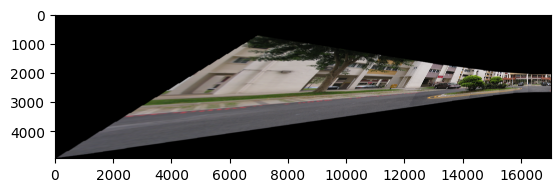

In [8]:
res1_image_path = r'C:\Users\Yashraj Deshmukh\Desktop\Panaroma-Stitching\results\I1\YashrajDeshmukh_stitcher_brutewarp.png'
res1_image = cv2.imread(res1_image_path)

if res1_image is not None:
    res1_image_rgb = cv2.cvtColor(res1_image, cv2.COLOR_BGR2RGB)
    plt.figure()
    # plt.axis('off')
    plt.imshow(res1_image_rgb)
    plt.show()
else:
    print(f"Error: Unable to load image at {res1_image_path}")


# Actual

In [23]:
import cv2
import os
import glob
import numpy as np
import logging

# Set up logging configuration
logging.basicConfig(
    filename='panorama_stitcher_trial.log',
    level=logging.DEBUG,
    format='%(asctime)s %(levelname)s:%(message)s'
)

def resize_image(image):
    """
    Resize the image based on its shape.
    
    Args:
    - image (numpy.ndarray): The input image.
    
    Returns:
    - numpy.ndarray: The resized image.
    """
    height, width, channels = image.shape
    
    if (height, width) == (2448, 3264) or (height, width) == (2658, 4000):
        # Reduce the size by a factor of 4
        new_height = height // 4
        new_width = width // 4
    elif (height, width) == (1329, 2000):
        # Reduce the size by half
        new_height = height // 2
        new_width = width // 2
    else:
        # Pass the image as it is
        return image
    
    # Log change in size
    logging.info("Resizing image from (%d, %d) to (%d, %d)", height, width, new_height, new_width)
    
    # Resize the image
    resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)
    
    return resized_image

class PanaromaStitcher():
    def __init__(self):
        pass

    def detect_and_match_features(self, image1, image2, nfeatures=100):
        """
        Detect keypoints and descriptors using SIFT and match them between two images.
        """
        try:
            sift = cv2.SIFT_create()  # Initialize SIFT detector
            keypoints_left, descriptors_left = sift.detectAndCompute(image1, None)
            keypoints_right, descriptors_right = sift.detectAndCompute(image2, None)

            # Initialize the BFMatcher
            bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
            # Match descriptors
            matches = bf.match(descriptors_left, descriptors_right)
            # Sort matches based on distance
            matches = sorted(matches, key=lambda x: x.distance)

            # Get the keypoints corresponding to the matches
            correspondences = []
            for match in matches[:nfeatures]:
                correspondences.append((keypoints_left[match.queryIdx].pt, keypoints_right[match.trainIdx].pt))

            # Log the number of matches found
            logging.info("Found %d matches between the images", len(matches))
            print(len(matches))
            
            return np.array(correspondences)

        except Exception as e:
            logging.error("Error in detect_and_match_features: %s", e)
            raise

    def _compute_homography(self, correspondences):
        """
        Computes the homography matrix from 4 pairs of correspondences.
        """
        A = []
        for (x, y), (x_prime, y_prime) in correspondences:
            A.append([-x, -y, -1, 0, 0, 0, x_prime * x, x_prime * y, x_prime])
            A.append([0, 0, 0, -x, -y, -1, y_prime * x, y_prime * y, y_prime])

        A = np.array(A)

        # Compute SVD of A
        _, _, Vt = np.linalg.svd(A)
        # The last row of Vt (or last column of V) gives the solution
        H = Vt[-1].reshape(3, 3)
        return H / H[-1, -1]  # Normalize so that H[2, 2] = 1
    
    def get_homography_via_RANSAC(self, correspondences, trials=1000, threshold=5.0):
        """
        Estimates the homography matrix using RANSAC.
        
        Parameters:
            correspondences (ndarray): Array of point pairs [(x1, y1), (x2, y2)].
            trials (int): Number of RANSAC iterations to perform.
            threshold (float): Distance threshold to consider a point an inlier.
            
        Returns:
            best_H (ndarray): Best homography matrix found.
            best_inliers (list): List of inliers that agree with best_H.
        """
        try:
            if len(correspondences) < 4:
                raise ValueError("Not enough matches to compute homography.")

            max_inliers = []
            best_H = None

            num_points = correspondences.shape[0]

            for _ in range(trials):
                # Randomly select 4 correspondences to compute the homography
                sample_indices = np.random.choice(num_points, 4, replace=False)
                sample_correspondences = correspondences[sample_indices]

                # Compute homography for the sample
                H = self._compute_homography(sample_correspondences)

                # Calculate the number of inliers
                inliers = []
                for (x, y), (x_prime, y_prime) in correspondences:
                    # Transform (x, y) using the estimated homography
                    transformed_point = np.dot(H, np.array([x, y, 1]))
                    transformed_point /= transformed_point[2]  # Normalize

                    # Calculate the Euclidean distance between the transformed and actual points
                    distance = np.linalg.norm(transformed_point[:2] - np.array([x_prime, y_prime]))

                    if distance < threshold:
                        inliers.append(((x, y), (x_prime, y_prime)))

                # Update the best homography if the current set has more inliers
                if len(inliers) > len(max_inliers):
                    max_inliers = inliers
                    best_H = H

            # Recompute the homography using all inliers of the best model
            if best_H is not None:
                best_H = self._compute_homography(max_inliers)

            print(len(max_inliers))
            return best_H

        except Exception as e:
            logging.error("Error in get_homography: %s", e)
            raise

    def _bilinear_interpolation(self, image, x, y):
        """
        Performs bilinear interpolation for the given (x, y) coordinates.

        Parameters:
            image (ndarray): The input image.
            x (float): The x-coordinate (non-integer) in the image.
            y (float): The y-coordinate (non-integer) in the image.

        Returns:
            interpolated_value (ndarray): The interpolated RGB value.
        """
        x1, y1 = int(x), int(y)
        x2, y2 = min(x1 + 1, image.shape[1] - 1), min(y1 + 1, image.shape[0] - 1)

        # Calculate the distances
        dx, dy = x - x1, y - y1

        # Get pixel values from the four corners
        top_left = image[y1, x1]
        top_right = image[y1, x2]
        bottom_left = image[y2, x1]
        bottom_right = image[y2, x2]

        # Interpolate along x for the top and bottom edges
        top = (1 - dx) * top_left + dx * top_right
        bottom = (1 - dx) * bottom_left + dx * bottom_right

        # Interpolate along y between the top and bottom edges
        interpolated_value = (1 - dy) * top + dy * bottom

        return np.clip(interpolated_value, 0, 255).astype(np.uint8)
    
    def _compute_bounding_box(self, left_image, H):
        """
        Computes the bounding box of the transformed left_image in the panorama space.

        Parameters:
            left_image (ndarray): The left image to be warped.
            H (ndarray): The homography matrix for transforming the left image.

        Returns:
            x_min, x_max, y_min, y_max (tuple): Bounding box coordinates for the transformed left image.
        """
        height, width = left_image.shape[:2]
        corners = np.array([[0, 0, 1], [width-1, 0, 1], [width-1, height-1, 1], [0, height-1, 1]]).T
        transformed_corners = H @ corners
        transformed_corners /= transformed_corners[2]  # Normalize by the homogeneous coordinate

        # Calculate min and max x, y coordinates for the bounding box
        x_min, x_max = int(np.floor(transformed_corners[0].min())), int(np.ceil(transformed_corners[0].max()))
        y_min, y_max = int(np.floor(transformed_corners[1].min())), int(np.ceil(transformed_corners[1].max()))

        return x_min, x_max, y_min, y_max

    def warp_image(self, left_image, H, right_image_shape):
        """
        Warps the left_image onto a larger canvas using homography H and places it within the appropriate bounding box.

        Parameters:
            left_image (ndarray): The left image to be transformed.
            H (ndarray): The homography matrix for transforming left_image.
            right_image_shape (tuple): The shape of the right image (height, width, channels).

        Returns:
            warped_canvas (ndarray): The transformed and warped image on the canvas.
            offset (tuple): The (x_offset, y_offset) for placing both images on the canvas.
        """
        # Compute bounding box of the transformed left image
        x_min, x_max, y_min, y_max = self._compute_bounding_box(left_image, H)

        # Calculate canvas dimensions and offset
        canvas_width = max(x_max, right_image_shape[1]) - min(x_min, 0)
        canvas_height = max(y_max, right_image_shape[0]) - min(y_min, 0)
        x_offset = -min(x_min, 0)
        y_offset = -min(y_min, 0)

        # Log bounding box, canvas dimensions, and offset
        logging.info("Bounding box: (%d, %d, %d, %d)", x_min, x_max, y_min, y_max)
        logging.info("Canvas dimensions: (%d, %d)", canvas_width, canvas_height)
        logging.info("Offset: (%d, %d)", x_offset, y_offset)

        # Initialize the canvas
        warped_canvas = np.zeros((canvas_height+1, canvas_width+1, 3), dtype=np.uint8)

        # Calculate inverse homography for mapping canvas pixels back to left_image coordinates
        H_inv = np.linalg.inv(H)

        # Generate grid of pixel coordinates within the bounding box
        x_coords, y_coords = np.meshgrid(np.arange(x_min, x_max + 1), np.arange(y_min, y_max + 1))
        coords_homogeneous = np.stack([x_coords.flatten(), y_coords.flatten(), np.ones_like(x_coords.flatten())])

        # Map canvas coordinates back to source (left_image) coordinates using inverse homography
        transformed_coords = H_inv @ coords_homogeneous
        transformed_coords /= transformed_coords[2]  # Normalize to get (x, y) coordinates in left_image

        x_src = transformed_coords[0].reshape(y_coords.shape)
        y_src = transformed_coords[1].reshape(y_coords.shape)

        # Apply bilinear interpolation on valid transformed coordinates and fill the canvas
        for i in range(y_coords.shape[0]):
            for j in range(x_coords.shape[1]):
                x, y = x_src[i, j], y_src[i, j]
                if 0 <= x < left_image.shape[1] and 0 <= y < left_image.shape[0]:
                    warped_canvas[y_coords[i, j] + y_offset, x_coords[i, j] + x_offset] = self._bilinear_interpolation(left_image, x, y)

        return warped_canvas, (x_offset, y_offset)

    def make_panaroma_for_images_in(self, all_images):
        """
        Load all images from the provided path and create a panorama by stitching them.

        Parameters:
            path (str): Directory containing images to stitch.

        Returns:
            stitched_image (ndarray): Final stitched panorama image.
            homography_matrix_list (list): List of homography matrices used in stitching.
        """
        try:
            # Load all images from the provided path
            # all_images = [r'C:\Users\Yashraj Deshmukh\Desktop\Panaroma-Stitching\Images\I3\3_3.jpg', r'C:\Users\Yashraj Deshmukh\Desktop\Panaroma-Stitching\Images\I3\3_4.jpg']
            logging.info('Found %d images for stitching', len(all_images))

            if len(all_images) < 2:
                raise ValueError("Need at least two images to create a panorama.")

            # Read the first image as the base image for the panorama
            base_image = cv2.imread(all_images[0])
            homography_matrix_list = []
            image_list = []

            for i in range(1, len(all_images)):
                next_image = cv2.imread(all_images[i])

                # Step 1: Detect and match features between consecutive images
                good_matches = self.detect_and_match_features(next_image, base_image)

                # Step 2: Compute the homography matrix between consecutive images
                H = self.get_homography_via_RANSAC(good_matches)
                homography_matrix_list.append(H)

                print(f"here1_{i}")

                # Step 3: Warp the right image and stitch with the base image
                warped_image, offset = self.warp_image(next_image, H, base_image.shape)

                # Superimpose the warped image onto the canvas
                x_offset, y_offset = offset
                panorama = warped_image
                panorama[y_offset:y_offset + base_image.shape[0], x_offset:x_offset + base_image.shape[1]] = base_image

                base_image = panorama
                image_list.append(base_image)

                print(f"here2_{i}")

                plt.figure()
                plt.axis('off')
                plt.imshow(base_image)

            return image_list, homography_matrix_list

        except Exception as e:
            logging.error("Error in make_panorama_for_images_in: %s", e)
            raise


In [11]:
c = PanaromaStitcher()
image, hm = c.make_panaroma_for_images_in()

here1_1
here2_1


In [12]:
hm

[array([[ 5.49653456e-01,  5.49108283e-03,  3.63012915e+02],
        [-9.19618047e-02,  8.82770533e-01,  2.11123000e+01],
        [-6.02340375e-04, -1.24541474e-05,  1.00000000e+00]])]

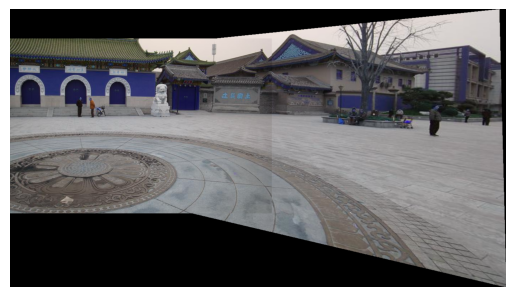

: 

In [15]:
plt.figure()
plt.axis('off')
plt.imshow(image)

In [9]:
d = PanaromaStitcher()
all_images = [r'C:\Users\Yashraj Deshmukh\Desktop\Panaroma-Stitching\Images\I3\3_3.jpg', r'C:\Users\Yashraj Deshmukh\Desktop\Panaroma-Stitching\Images\I3\3_4.jpg', r'C:\Users\Yashraj Deshmukh\Desktop\Panaroma-Stitching\Images\I3\3_5.jpg']
image, hm = d.make_panaroma_for_images_in(all_images)

here1_1
here2_1
here1_2
here2_2


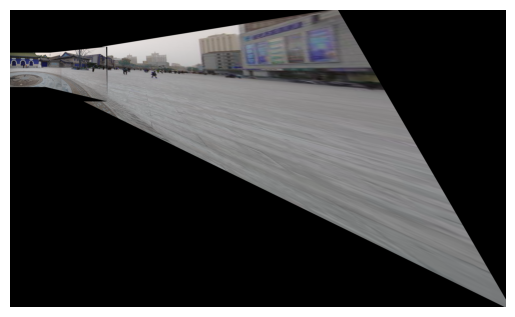

In [12]:
plt.figure()
plt.axis('off')
plt.imshow(image)

here1_1
here2_1
here1_2
here2_2


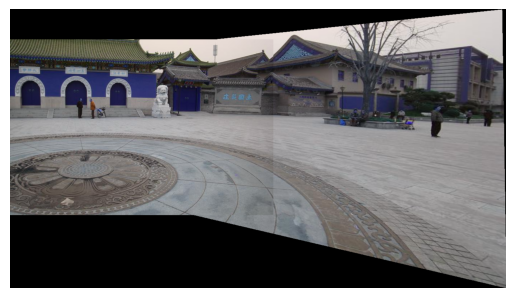

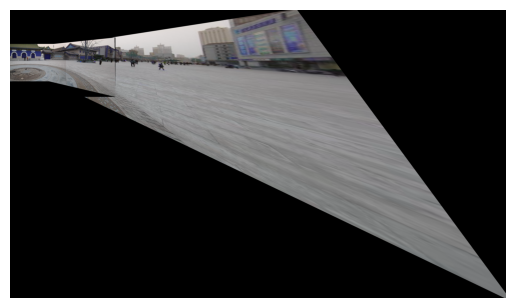

In [14]:
e = PanaromaStitcher()
images, hm = e.make_panaroma_for_images_in(all_images)

589


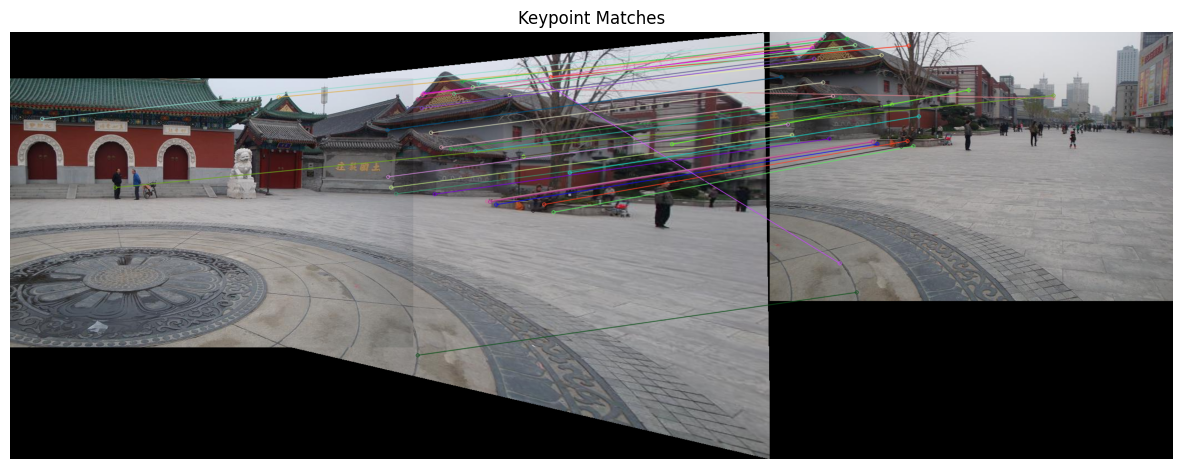

In [19]:
right_image_path = r'C:\Users\Yashraj Deshmukh\Desktop\Panaroma-Stitching\Images\I3\3_5.jpg'

left_image = images[0]
right_image = cv2.imread(right_image_path)

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect SIFT features and compute descriptors
keypoints_left, descriptors_left = sift.detectAndCompute(left_image, None)
keypoints_right, descriptors_right = sift.detectAndCompute(right_image, None)

# Initialize the BFMatcher
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# Match descriptors
matches = bf.match(descriptors_left, descriptors_right)

# Sort matches based on distance
matches = sorted(matches, key=lambda x: x.distance)

print(len(matches))

# Draw the matches
matched_image = cv2.drawMatches(left_image, keypoints_left, right_image, keypoints_right, matches[:40], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the matched images using matplotlib
plt.figure(figsize=(15, 10))
plt.title('Keypoint Matches')
plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

527
92
here1_1
here2_1
593
59
here1_2
here2_2


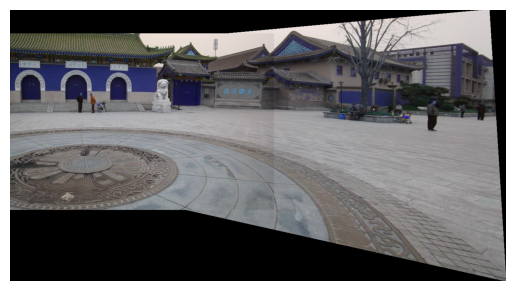

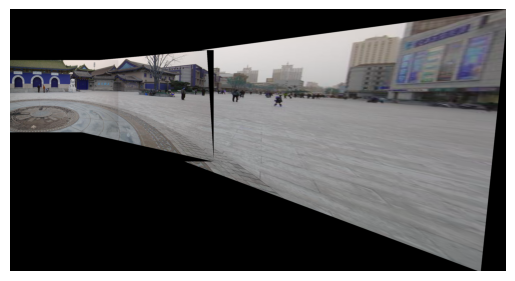

In [24]:
f = PanaromaStitcher()
images, hm = f.make_panaroma_for_images_in(all_images)

491
79
here1_1
here2_1
589
89
here1_2
here2_2


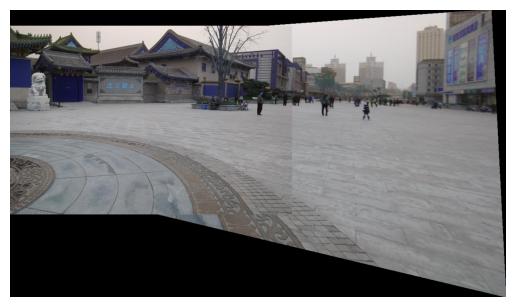

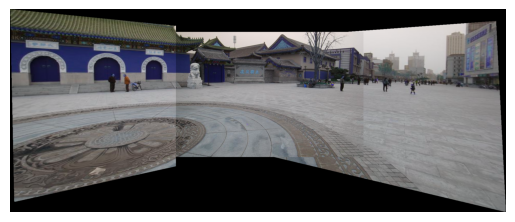

In [25]:
g = PanaromaStitcher()
all_images = [r'C:\Users\Yashraj Deshmukh\Desktop\Panaroma-Stitching\Images\I3\3_4.jpg', r'C:\Users\Yashraj Deshmukh\Desktop\Panaroma-Stitching\Images\I3\3_5.jpg', r'C:\Users\Yashraj Deshmukh\Desktop\Panaroma-Stitching\Images\I3\3_3.jpg']
images, hm = g.make_panaroma_for_images_in(all_images)

# Actual - 2

In [3]:
import cv2
import os
import glob
import numpy as np
import logging

# Set up logging configuration
logging.basicConfig(
    filename='panorama_stitcher_trial.log',
    level=logging.DEBUG,
    format='%(asctime)s %(levelname)s:%(message)s'
)

def resize_image(image):
    """
    Resize the image based on its shape.
    
    Args:
    - image (numpy.ndarray): The input image.
    
    Returns:
    - numpy.ndarray: The resized image.
    """
    height, width, channels = image.shape
    
    if (height, width) == (2448, 3264) or (height, width) == (2658, 4000):
        # Reduce the size by a factor of 4
        new_height = height // 4
        new_width = width // 4
    elif (height, width) == (1329, 2000):
        # Reduce the size by half
        new_height = height // 2
        new_width = width // 2
    else:
        # Pass the image as it is
        return image
    
    # Log change in size
    logging.info("Resizing image from (%d, %d) to (%d, %d)", height, width, new_height, new_width)
    
    # Resize the image
    resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)
    
    return resized_image

class PanaromaStitcher2():
    def __init__(self):
        pass

    def detect_and_match_features(self, image1, image2, nfeatures=100):
        """
        Detect keypoints and descriptors using SIFT and match them between two images.
        """
        try:
            sift = cv2.SIFT_create()  # Initialize SIFT detector
            keypoints_left, descriptors_left = sift.detectAndCompute(image1, None)
            keypoints_right, descriptors_right = sift.detectAndCompute(image2, None)

            # Initialize the BFMatcher
            bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
            # Match descriptors
            matches = bf.match(descriptors_left, descriptors_right)
            # Sort matches based on distance
            matches = sorted(matches, key=lambda x: x.distance)

            # Get the keypoints corresponding to the matches
            correspondences = []
            for match in matches[:nfeatures]:
                correspondences.append((keypoints_left[match.queryIdx].pt, keypoints_right[match.trainIdx].pt))

            # Log the number of matches found
            logging.info("Found %d matches between the images", len(matches))
            
            return np.array(correspondences)

        except Exception as e:
            logging.error("Error in detect_and_match_features: %s", e)
            raise

    def _compute_homography(self, correspondences):
        """
        Computes the homography matrix from 4 pairs of correspondences.
        """
        A = []
        for (x, y), (x_prime, y_prime) in correspondences:
            A.append([-x, -y, -1, 0, 0, 0, x_prime * x, x_prime * y, x_prime])
            A.append([0, 0, 0, -x, -y, -1, y_prime * x, y_prime * y, y_prime])

        A = np.array(A)

        # Compute SVD of A
        _, _, Vt = np.linalg.svd(A)
        # The last row of Vt (or last column of V) gives the solution
        H = Vt[-1].reshape(3, 3)
        return H / H[-1, -1]  # Normalize so that H[2, 2] = 1
    
    def get_homography_via_RANSAC(self, correspondences, trials=1000, threshold=5.0):
        """
        Estimates the homography matrix using RANSAC.
        
        Parameters:
            correspondences (ndarray): Array of point pairs [(x1, y1), (x2, y2)].
            trials (int): Number of RANSAC iterations to perform.
            threshold (float): Distance threshold to consider a point an inlier.
            
        Returns:
            best_H (ndarray): Best homography matrix found.
            best_inliers (list): List of inliers that agree with best_H.
        """
        try:
            if len(correspondences) < 4:
                raise ValueError("Not enough matches to compute homography.")

            max_inliers = []
            best_H = None

            num_points = correspondences.shape[0]

            for _ in range(trials):
                # Randomly select 4 correspondences to compute the homography
                sample_indices = np.random.choice(num_points, 4, replace=False)
                sample_correspondences = correspondences[sample_indices]

                # Compute homography for the sample
                H = self._compute_homography(sample_correspondences)

                # Calculate the number of inliers
                inliers = []
                for (x, y), (x_prime, y_prime) in correspondences:
                    # Transform (x, y) using the estimated homography
                    transformed_point = np.dot(H, np.array([x, y, 1]))
                    transformed_point /= transformed_point[2]  # Normalize

                    # Calculate the Euclidean distance between the transformed and actual points
                    distance = np.linalg.norm(transformed_point[:2] - np.array([x_prime, y_prime]))

                    if distance < threshold:
                        inliers.append(((x, y), (x_prime, y_prime)))

                # Update the best homography if the current set has more inliers
                if len(inliers) > len(max_inliers):
                    max_inliers = inliers
                    best_H = H

            # Recompute the homography using all inliers of the best model
            if best_H is not None:
                best_H = self._compute_homography(max_inliers)

            # Log the number of inliers and the best homography matrix
            logging.info("Number of inliers: %d", len(max_inliers))
            logging.info("Best homography matrix:\n%s", best_H)

            return best_H

        except Exception as e:
            logging.error("Error in get_homography: %s", e)
            raise

    def _bilinear_interpolation(self, image, x, y):
        """
        Performs bilinear interpolation for the given (x, y) coordinates.

        Parameters:
            image (ndarray): The input image.
            x (float): The x-coordinate (non-integer) in the image.
            y (float): The y-coordinate (non-integer) in the image.

        Returns:
            interpolated_value (ndarray): The interpolated RGB value.
        """
        x1, y1 = int(x), int(y)
        x2, y2 = min(x1 + 1, image.shape[1] - 1), min(y1 + 1, image.shape[0] - 1)

        # Calculate the distances
        dx, dy = x - x1, y - y1

        # Get pixel values from the four corners
        top_left = image[y1, x1]
        top_right = image[y1, x2]
        bottom_left = image[y2, x1]
        bottom_right = image[y2, x2]

        # Interpolate along x for the top and bottom edges
        top = (1 - dx) * top_left + dx * top_right
        bottom = (1 - dx) * bottom_left + dx * bottom_right

        # Interpolate along y between the top and bottom edges
        interpolated_value = (1 - dy) * top + dy * bottom

        return np.clip(interpolated_value, 0, 255).astype(np.uint8)
    
    def _compute_bounding_box(self, left_image, H):
        """
        Computes the bounding box of the transformed left_image in the panorama space.

        Parameters:
            left_image (ndarray): The left image to be warped.
            H (ndarray): The homography matrix for transforming the left image.

        Returns:
            x_min, x_max, y_min, y_max (tuple): Bounding box coordinates for the transformed left image.
        """
        height, width = left_image.shape[:2]
        corners = np.array([[0, 0, 1], [width, 0, 1], [width, height, 1], [0, height, 1]]).T
        transformed_corners = H @ corners
        transformed_corners /= transformed_corners[2]  # Normalize by the homogeneous coordinate

        # Calculate min and max x, y coordinates for the bounding box
        x_min, x_max = int(np.floor(transformed_corners[0].min())), int(np.ceil(transformed_corners[0].max()))
        y_min, y_max = int(np.floor(transformed_corners[1].min())), int(np.ceil(transformed_corners[1].max()))

        return x_min, x_max, y_min, y_max

    def warp_image(self, left_image, H, right_image_shape, interpolate=False):
        """
        Warps the left_image onto a larger canvas using homography H and places it within the appropriate bounding box.

        Parameters:
            left_image (ndarray): The left image to be transformed.
            H (ndarray): The homography matrix for transforming left_image.
            right_image_shape (tuple): The shape of the right image (height, width, channels).

        Returns:
            warped_canvas (ndarray): The transformed and warped image on the canvas.
            offset (tuple): The (x_offset, y_offset) for placing both images on the canvas.
        """
        # Compute bounding box of the transformed left image
        x_min, x_max, y_min, y_max = self._compute_bounding_box(left_image, H)

        # Calculate canvas dimensions and offset
        canvas_width = max(x_max, right_image_shape[1]) - min(x_min, 0)
        canvas_height = max(y_max, right_image_shape[0]) - min(y_min, 0)
        x_offset = -min(x_min, 0)
        y_offset = -min(y_min, 0)

        # Log bounding box, canvas dimensions, and offset
        logging.info("Bounding box: (%d, %d, %d, %d)", x_min, x_max, y_min, y_max)
        logging.info("Canvas dimensions: (%d, %d)", canvas_width, canvas_height)
        logging.info("Offset: (%d, %d)", x_offset, y_offset)

        # Initialize the canvas
        warped_canvas = np.zeros((canvas_height+1, canvas_width+1, 3), dtype=np.uint8)

        # Calculate inverse homography for mapping canvas pixels back to left_image coordinates
        H_inv = np.linalg.inv(H)

        # Generate grid of pixel coordinates within the bounding box
        x_coords, y_coords = np.meshgrid(np.arange(x_min, x_max + 1), np.arange(y_min, y_max + 1))
        coords_homogeneous = np.stack([x_coords.flatten(), y_coords.flatten(), np.ones_like(x_coords.flatten())])

        if interpolate:
            # Map canvas coordinates back to source (left_image) coordinates using inverse homography
            transformed_coords = H_inv @ coords_homogeneous
            transformed_coords /= transformed_coords[2]  # Normalize to get (x, y) coordinates in left_image

            x_src = transformed_coords[0].reshape(y_coords.shape)
            y_src = transformed_coords[1].reshape(y_coords.shape)

            # Apply bilinear interpolation on valid transformed coordinates and fill the canvas
            for i in range(y_coords.shape[0]):
                for j in range(x_coords.shape[1]):
                    x, y = x_src[i, j], y_src[i, j]
                    if 0 <= x < left_image.shape[1] and 0 <= y < left_image.shape[0]:
                        warped_canvas[y_coords[i, j] + y_offset, x_coords[i, j] + x_offset] = self._bilinear_interpolation(left_image, x, y)
        else:
            # Map canvas coordinates back to source (left_image) coordinates using inverse homography
            transformed_coords = np.einsum('ij,jk->ik', H_inv, coords_homogeneous)
            transformed_coords /= transformed_coords[2]  # Normalize to get (x, y) coordinates in left_image

            # Reshape to match canvas grid
            x_src = transformed_coords[0].reshape(y_coords.shape).round().astype(int)
            y_src = transformed_coords[1].reshape(y_coords.shape).round().astype(int)

            # Mask to keep coordinates within the source image bounds
            mask = (0 <= x_src) & (x_src < left_image.shape[1]) & (0 <= y_src) & (y_src < left_image.shape[0])

            # Fill the warped canvas with valid mapped pixels
            warped_canvas[y_coords[mask] + y_offset, x_coords[mask] + x_offset] = left_image[y_src[mask], x_src[mask]]

        return warped_canvas, (x_offset, y_offset)

    def make_panaroma_for_images_in(self, all_images):
        """
        Load all images from the provided path and create a panorama by stitching them.

        Parameters:
            path (str): Directory containing images to stitch.

        Returns:
            stitched_image (ndarray): Final stitched panorama image.
            homography_matrix_list (list): List of homography matrices used in stitching.
        """
        try:
            # Load all images from the provided path
            # all_images = sorted(glob.glob(path + os.sep + '*'))
            logging.info('Found %d images for stitching', len(all_images))

            if len(all_images) < 2:
                raise ValueError("Need at least two images to create a panorama.")

            # Read the first image as the base image for the panorama
            base_image = resize_image(cv2.imread(all_images[0]))
            homography_matrix_list = []

            for i in range(1, len(all_images)):
                next_image = resize_image(cv2.imread(all_images[i]))

                print(f"here0_{i}")

                # Step 1: Detect and match features between consecutive images
                good_matches = self.detect_and_match_features(next_image, base_image)

                # Step 2: Compute the homography matrix between consecutive images
                H = self.get_homography_via_RANSAC(good_matches)
                homography_matrix_list.append(H)

                print(f"here1_{i}")

                # Step 3: Warp the right image and stitch with the base image
                warped_image, offset = self.warp_image(next_image, H, base_image.shape)

                # Superimpose the warped image onto the canvas
                x_offset, y_offset = offset
                panorama = warped_image
                panorama[y_offset:y_offset + base_image.shape[0], x_offset:x_offset + base_image.shape[1]] = base_image

                base_image = panorama

                print(f"here2_{i}")

            # Return final stitched image and all homography matrices
            stitched_image = base_image
            return stitched_image, homography_matrix_list

        except Exception as e:
            logging.error("Error in make_panorama_for_images_in: %s", e)
            raise


In [4]:
p2 = PanaromaStitcher2()
all_images = [r'C:\Users\Yashraj Deshmukh\Desktop\Panaroma-Stitching\Images\I4\DSC02930.jpg', r'C:\Users\Yashraj Deshmukh\Desktop\Panaroma-Stitching\Images\I4\DSC02931.jpg', r'C:\Users\Yashraj Deshmukh\Desktop\Panaroma-Stitching\Images\I4\DSC02932.jpg', r'C:\Users\Yashraj Deshmukh\Desktop\Panaroma-Stitching\Images\I4\DSC02933.jpg', r'C:\Users\Yashraj Deshmukh\Desktop\Panaroma-Stitching\Images\I4\DSC02934.jpg']
images, hm = p2.make_panaroma_for_images_in(all_images)

here0_1
here1_1
here2_1
here0_2
here1_2
here2_2
here0_3
here1_3
here2_3
here0_4
here1_4
here2_4


C:\Users\Yashraj Deshmukh\AppData\Local\Temp\ipykernel_29808\233375526.py:271: RuntimeWarning: invalid value encountered in cast
  x_src = transformed_coords[0].reshape(y_coords.shape).round().astype(int)
C:\Users\Yashraj Deshmukh\AppData\Local\Temp\ipykernel_29808\233375526.py:272: RuntimeWarning: invalid value encountered in cast
  y_src = transformed_coords[1].reshape(y_coords.shape).round().astype(int)


In [5]:
a = np.array([[1],[0]])
a[0]/a[1]

C:\Users\Yashraj Deshmukh\AppData\Local\Temp\ipykernel_29808\770834638.py:2: RuntimeWarning: divide by zero encountered in divide
  a[0]/a[1]


array([inf])